# Cyclic peptides

In [2]:
import pandas as pd
df_all= pd.read_csv('data/CycPeptMPDB/all.csv')
df_train = pd.read_csv('data/CycPeptMPDB/train.csv')
df_test = pd.read_csv('data/CycPeptMPDB/test.csv')

pd.set_option('display.max_colwidth', None)

display(df_all.head()['helm'])

y_train = df_train.score.values
y_test = df_test.score.values
y_all = df_all.score.values

## Feature processing

### Fingerprints (fps)

In [4]:
import warnings
import numpy as np
from rdkit import Chem, rdBase, DataStructs
from rdkit.Chem import AllChem
from typing import List

rdBase.DisableLog('rdApp.error')
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

def fingerprints_from_smiles(smiles: List, size=2048):
    """
        Create ECFP fingerprints of smiles, with validity check
    """
    fps = []
    valid_mask = []
    for i, smile in enumerate(smiles):
        mol = Chem.MolFromSmiles(smile)
        valid_mask.append(int(mol is not None))
        fp = fingerprints_from_mol(mol, size=size) if mol else np.zeros((1, size))
        fps.append(fp)

    fps = np.concatenate(fps, axis=0)
    return fps, valid_mask


def fingerprints_from_mol(molecule, radius=3, size=2048, hashed=False):
    """
        Create ECFP fingerprint of a molecule
    """
    if hashed:
        fp_bits = AllChem.GetHashedMorganFingerprint(molecule, radius, nBits=size)
    else:
        fp_bits = AllChem.GetMorganFingerprintAsBitVect(molecule, radius, nBits=size)
    fp_np = np.zeros((1,))
    DataStructs.ConvertToNumpyArray(fp_bits, fp_np)
    return fp_np.reshape(1, -1)

In [30]:
# train = True
train = False
if train:
    X_all = fingerprints_from_smiles(df_all.smi)[0]
    X_train = fingerprints_from_smiles(df_train.smi)[0]
    X_test = fingerprints_from_smiles(df_test.smi)[0]

    np.save('data/CycPeptMPDB/X_all_fps.npy', X_train)
    np.save('data/CycPeptMPDB/X_train_fps.npy', X_train)
    np.save('data/CycPeptMPDB/X_test_fps.npy', X_test)
else:
    X_all = np.load('data/CycPeptMPDB/X_all_fps.npy')
    X_train = np.load('data/CycPeptMPDB/X_train_fps.npy')
    X_test = np.load('data/CycPeptMPDB/X_test_fps.npy')

X_all.shape, y_all.shape, X_train.shape, y_train.shape, X_test.shape, y_test.shape

((5960, 2048), (7451,), (5960, 2048), (5960,), (1491, 2048), (1491,))

### 2D descriptors

In [48]:
import warnings
import numpy as np
from rdkit import Chem, rdBase, DataStructs
from rdkit.Chem import AllChem
from typing import List
from rdkit import rdBase, Chem
from rdkit.Chem import Descriptors, rdMolDescriptors

rdBase.DisableLog('rdApp.error')
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)


def get_2d_descriptor_from_mol(m):
    """
    Calculate 2D descriptors from mol object
    :param m: mol object
    :return: 2D descriptors including MW, LogP, TPSA, HBD, HBA, PHI, numAtom, 
    """
    mw = Descriptors.MolWt(m)
    logp = Descriptors.MolLogP(m)

    tpsa = Descriptors.TPSA(mol)  # Topological polar surface area
    hbd = rdMolDescriptors.CalcNumLipinskiHBD(m)  # Number of hydrogen-bond donors
    hba = rdMolDescriptors.CalcNumLipinskiHBA(m)  # Number of hydrogen-bond acceptors
    n_rb = Chem.rdMolDescriptors.CalcNumRotatableBonds(mol)  # Number of rotatable bonds
    n_atom = m.GetNumAtoms()  # Number of atoms
    return np.array([mw, logp, tpsa, hbd, hba, n_rb, n_atom])

# get_2d_descriptor_from_mol(mol)


def get_2d_descriptor_from_smiles(smiles: List, size=7):
    """
        Create 2d descriptors of smiles, with validity check
    """
    dps = []
    valid_mask = []
    for i, smile in enumerate(smiles):
        mol = Chem.MolFromSmiles(smile)
        valid_mask.append(int(mol is not None))
        dp = get_2d_descriptor_from_mol(mol) if mol else np.zeros(size)
        dps.append(dp)

    dps = np.vstack(dps)
    return dps, valid_mask

In [51]:
train = True
# train = False
if train:
    X_all = get_2d_descriptor_from_smiles(df_all.smi)[0]
    X_train = get_2d_descriptor_from_smiles(df_train.smi)[0]
    X_test = get_2d_descriptor_from_smiles(df_test.smi)[0]

    np.save('data/CycPeptMPDB/X_all_2dps.npy', X_train)
    np.save('data/CycPeptMPDB/X_train_2dps.npy', X_train)
    np.save('data/CycPeptMPDB/X_test_2dps.npy', X_test)
else:
    X_all = np.load('data/CycPeptMPDB/X_all_2dps.npy')
    X_train = np.load('data/CycPeptMPDB/X_train_2dps.npy')
    X_test = np.load('data/CycPeptMPDB/X_test_2dps.npy')

X_all.shape, y_all.shape, X_train.shape, y_train.shape, X_test.shape, y_test.shape

((7451, 7), (7451,), (5960, 7), (5960,), (1491, 7), (1491,))

### Final features

In [56]:
# features = ['fps', ]
# features = ['2dps', ]
# features = ['smi_bert', ]
# features = ['helm_bert', ]
features = ['fps', '2dps', ]
# features = ['smi_bert', 'helm_bert', ]

X_all_features = []
X_train_features = []
X_test_features = []
for feat in features:
    try:
        X_all = np.load(f'data/CycPeptMPDB/X_all_{feat}.npy')
        X_train = np.load(f'data/CycPeptMPDB/X_train_{feat}.npy')
        X_test = np.load(f'data/CycPeptMPDB/X_test_{feat}.npy')

        X_all_features.append(X_all)
        X_train_features.append(X_train)
        X_test_features.append(X_test)
    except:
        raise ValueError(f'Feature {feat} not supported')

X_all = np.concatenate(X_all_features, axis=1)
X_train = np.concatenate(X_train_features, axis=1)
X_test = np.concatenate(X_test_features, axis=1)

X_all.shape, y_all.shape, X_train.shape, y_train.shape, X_test.shape, y_test.shape

((5960, 2055), (7451,), (5960, 2055), (5960,), (1491, 2055), (1491,))

## Modeling

In [57]:
import matplotlib.pyplot as plt
from utils.utils import get_regresssion_metrics

def plot_scatter_y(y, y_hat, x_label='y', y_label='y_hat', save_path=None):
    plt.scatter(y, y_hat, alpha=0.1)
    get_regresssion_metrics(y, y_hat)
    mae = np.mean(np.abs(y - y_hat))
    print(f'MAE: {mae:.3f}, y mean: {np.mean(y):.3f}, y_hat mean: {np.mean(y_hat):.3f}')
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    if save_path:
        plt.savefig(save_path+f'_{mae:.3f}.pdf', dpi=300, bbox_inches='tight')
    plt.show()

### XGBoost regressor

MAE 	 MSE 	 R2 	 Spearman 	 Pearson
0.484	0.712	-0.122	0.782	0.651
MAE: 0.484, y mean: -5.876, y_hat mean: -5.864


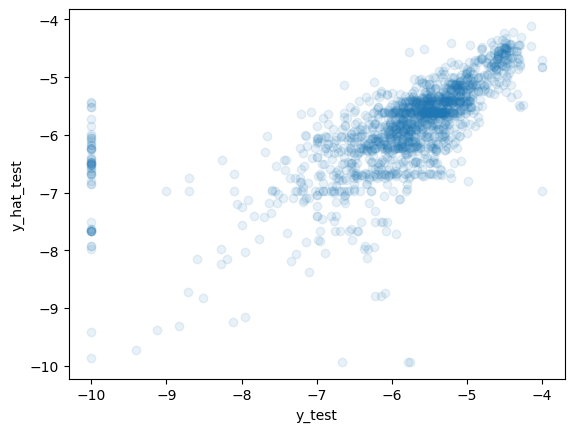

In [58]:
from xgboost import XGBRegressor

is_cv = False
is_save = False
save_path='data/CycPeptMPDB/fps_xgbr.model'

if is_cv:
    from numpy import absolute
    from sklearn.model_selection import RepeatedKFold, cross_val_score

    model = XGBRegressor(n_estimators=1000, max_depth=7, eta=0.1, subsample=0.7, colsample_bytree=0.8)
    cv = RepeatedKFold(n_splits=10, n_repeats=5, random_state=1)
    scores = cross_val_score(model, X_all, y_all, scoring='neg_mean_absolute_error', cv=cv, n_jobs=None)    # 16 min
    scores = absolute(scores)
    print('Mean MAE: %.3f (%.3f)' % (scores.mean(), scores.std()) )
else:
    model = XGBRegressor(n_estimators=1000, max_depth=7, eta=0.1, subsample=0.7, colsample_bytree=0.8)
    model.fit(X_train, y_train)
    if is_save:
        joblib.dump(model, save_path)
        model = joblib.load(save_path)
    y_hat = model.predict(X_test)
    plot_scatter_y(y_test, y_hat, x_label='y_test', y_label='y_hat_test', save_path=save_path)

### RF regressor

MAE 	 MSE 	 R2 	 Spearman 	 Pearson
0.567	0.867	-1.966	0.648	0.543
MAE: 0.567, y mean: -5.876, y_hat mean: -5.863


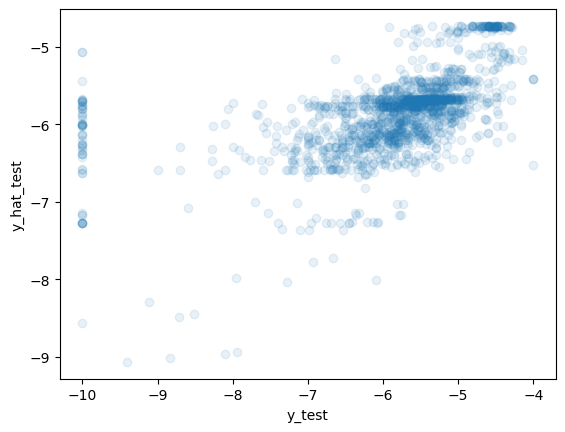

In [60]:
from sklearn.ensemble import RandomForestRegressor
import joblib

is_cv = False
is_save = False
save_path='data/CycPeptMPDB/fps_rf.model'

if is_cv:
    from numpy import absolute
    from sklearn.model_selection import RepeatedKFold, cross_val_score

    model = RandomForestRegressor(max_depth=5, random_state=0)
    cv = RepeatedKFold(n_splits=10, n_repeats=5, random_state=1)
    scores = cross_val_score(model, X_all, y_all, scoring='neg_mean_absolute_error', cv=cv, n_jobs=None)    # 16 min
    scores = absolute(scores)
    print('Mean MAE: %.3f (%.3f)' % (scores.mean(), scores.std()) )
else:
    model = RandomForestRegressor(max_depth=5, random_state=0)
    model.fit(X_train, y_train)
    if is_save:
        joblib.dump(model, save_path)
        model = joblib.load(save_path)
    y_hat = model.predict(X_test)
    # model.save_model(save_path)
    plot_scatter_y(y_test, y_hat, x_label='y_test', y_label='y_hat_test', save_path=save_path)